In [1]:
import arviz as az

import matplotlib.pyplot as plt

import numpy as np

import pymc3 as pm

from collections import (defaultdict,
                         Counter)

from sklearn.neighbors import KDTree
from sklearn.preprocessing import scale

from scipy.spatial import distance

import pandas as pd

from tqdm.notebook import trange

from nltk.corpus import (brown, 
                         wordnet)
import nltk

# nltk.download('brown')
# nltk.download('words')
# nltk.download('universal_tagset')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

### 1. Load corpus: 

In [2]:
words = set(nltk.corpus.words.words())

tagged_words = brown.tagged_words(tagset='universal')
l_t_w = [(i[0].lower(), i[1]) for i in tagged_words if i[0] in words]
POS_t = dict(l_t_w)
fdist = dict(nltk.FreqDist(w[0] for w in l_t_w))
total = sum(fdist.values())
fdist_rel = {k: v / total for k, v in fdist.items()}
freq_d = pd.DataFrame.from_dict(fdist_rel, orient='index').reset_index()
freq_d.columns = ['word', 'freq']
freq_d['POS'] = freq_d['word'].map(POS_t)
df_nouns = freq_d.query("POS == 'NOUN'").sort_values('freq', ascending=False).reset_index(drop=True)
df_nouns['rank'] = df_nouns['freq'].rank(method='min', ascending=False)
df_nouns['n_sunsets'] = df_nouns['word'].apply(lambda w: len(wordnet.synsets(w)))
df_nouns['len'] = df_nouns['word'].apply(len)

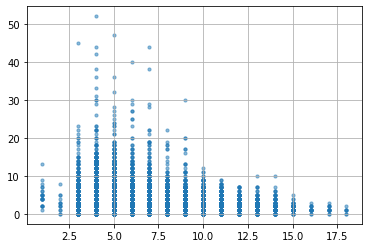

In [3]:
plt.scatter(df_nouns['len'], df_nouns['n_sunsets'], alpha=0.5, s=10)
plt.grid()

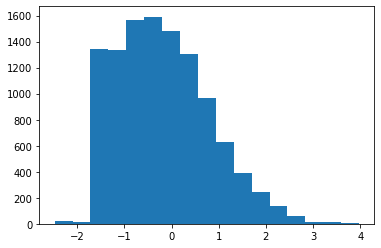

In [4]:
_ = plt.hist(scale(df_nouns['len']), bins=17)

In [5]:
np.random.choice(scale(df_nouns['len']))

0.9376996332294391

In [6]:
np.random.choice(df_nouns['len'])

11

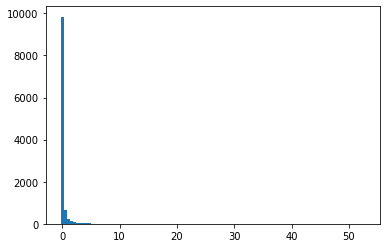

In [7]:
_ = plt.hist(scale(df_nouns['freq']), bins=100)

In [8]:
subset1000 = df_nouns.sort_values(by='freq', ascending=False).iloc[0:1000]

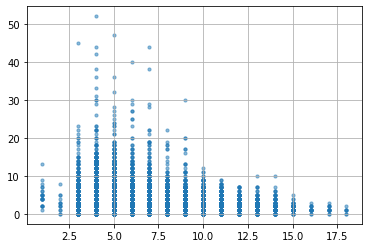

In [9]:
plt.scatter(df_nouns['len'], df_nouns['n_sunsets'], alpha=0.5, s=10)
plt.grid()

In [10]:
df_nouns.shape

(11113, 6)

### 2. Model:

In [11]:
class Word:
    def __init__(self, id_generator):
        self.id = next(id_generator)
        self.senses = []
        self.length = 0
        self.freq = 0

In [20]:
def sense_modelv1(epochs=10000, treshold=3, a=10, b=1, c=1):
    generator = iter(range(10000000))
    senses_w = {}
    senses = np.empty([1, 2])
    words = []

    for _ in range(4):
        senses = np.append(senses, 
                           np.random.uniform(0, 1000, [1, 2]),
                           axis=0)
        new_w = Word(generator)
        new_w.senses.append(senses[-1])
        new_w.length = np.random.choice(df_nouns['len'])
        new_w.freq = np.random.choice(df_nouns['freq'])
        words.append(new_w)
        senses_w[bytes(senses[-1])] = new_w
        
    senses = np.delete(senses, 0, axis=0)
    
#     while len(words) < 1000:
    for _ in trange(epochs):
        senses = np.append(senses, 
                           np.random.uniform(0, 1000, [1, 2]),
                           axis=0)
        tree = KDTree(senses, leaf_size=2)
        dist, ind = tree.query(senses[-1].reshape(1, -1), k=5)

        res = senses[ind[(dist > 0) & (dist < treshold)]]

        if len(res) > 0:
            senss = []
            probb = []
            for sense in res:
                word = senses_w.get(sense.tobytes())
                senss.append(sense)
                probb.append((1/word.length)**a * 
                             (1/distance.euclidean(sense, senses[-1]))**b * 
                             (1/word.freq)**c)
            probb = [_/sum(probb) for _ in probb]
            best_match = senses_w.get(senss[np.random.choice([_ for _ in range(len(senss))],
                                                             p=probb)].tobytes())
            best_match.senses.append(senses[-1])
            senses_w[senses[-1].tobytes()] = best_match 
        else:
            new_w = Word(generator)
            new_w.length = np.random.choice(df_nouns['len'])
            new_w.freq = np.random.choice(df_nouns['freq'])
            senses_w[senses[-1].tobytes()] = new_w 
            new_w.senses.append(senses[-1])
            words.append(new_w)
    counts_sen = [len(i.senses) for i in senses_w.values()]
    counts_length = [i.length for i in senses_w.values()]
    
    return counts_sen, counts_length, senses, words

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.0, 20.0)

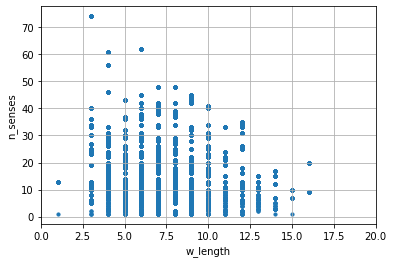

In [33]:
s, l, ss, words = sense_modelv1(epochs=10000,
                     a=1,
                     b=1,
                     c=1,
                     treshold=20)

plt.scatter(l, s, s=10)
plt.ylabel('n_senses')
plt.xlabel('w_length')
plt.grid()
plt.xlim(0, 20)

(0.0, 20.0)

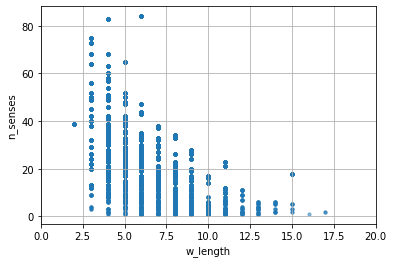

In [35]:
s, l, ss, words = sense_modelv1(epochs=10000,
                     a=20,
                     b=1,
                     c=1,
                     treshold=20)

plt.scatter(l, s, s=10, alpha=0.5)
plt.ylabel('n_senses')
plt.xlabel('w_length')
plt.grid()
plt.xlim(0, 20)

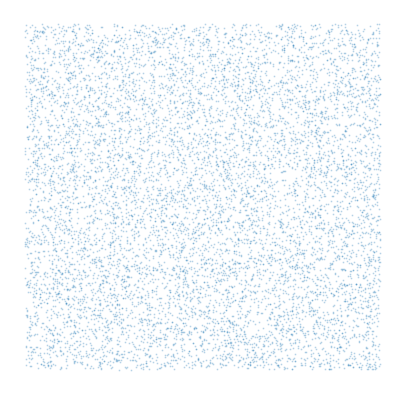

In [36]:
cmap = plt.get_cmap('gist_ncar')
plt.figure(figsize=(7, 7))
plt.scatter(ss[:, 0], ss[:, 1], s=1, alpha=0.2)
_ = plt.axis('off')